# Feature selection ;)

In [305]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [306]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [307]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [308]:
dataset.shape

(53082, 58)

In [309]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                
                # 'HBV_SUR_ANTIGEN', # negative importance
                # "ABO", # negative importance
                # "ABO_DON", # negative importance
                # 'HBV_SUR_ANTIGEN_DON',  # negative importance
                # "GENDER_DON", # negative importance
                # "DIABETES_DON", # zero importance
                
            ]
yes_numerical = [   
                # "KI_CREAT_PREOP",
                "SERUM_CREAT",
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON",
                "DIALYSIS_TIME",
                # "KDPI",

                # HLA with some importance
                # 'DR1', 
                # 'BW6', 
                # 'BW4', 
                # 'RA1',
                # 'A2', 
                # 'DR53', 
                # 'C1', 
                # 'C2', 
                # 'A1',
                # 'RA2', 
                # 'DR51',
                # 'DR52', 
                # 'DQ2', 
                # 'RDR1',
                
                # 'BMIS', # negative importance
                # 'AMIS', # negative importance    
                # 'DR52_2', # zero importance
                # 'DR53_2', # zero importance
                # 'B2', # negative importance
                # "CREAT_TRR", # negative importance
                # 'DR2', # negative importance
                # 'RB1',# negative importance
                # 'B1', # negative importance
                # "BMI_CALC", # negative importance 
                # "WGT_KG_CALC", # negative importance
                # "WGT_KG_DON_CALC", # negative importance
                # "HGT_CM_DON_CALC", # negative importance
                # 'DQ1',# negative importance
                # 'RB2',# negative importance
                # 'RDR2',# negative importance
                ]

In [310]:
dataset[yes_numerical].quantile([0.01, 0.99])

,DIALYSIS_TIME
0.01,0.00
0.99,3100.76


In [311]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

SERUM_CREAT      float64
NPKID            float64
AGE              float64
HGT_CM_CALC      float64
BMI_DON_CALC     float64
AGE_DON          float64
DIALYSIS_TIME    float64
dtype: object

In [312]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

def preprocess_data(feature_importance):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
    ])
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, yes_numerical),
                ('cat', categorical_transformer, yes_categorical)
            ]
        )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    if feature_importance:
        categorical_x = encode_categorical(dataset[yes_categorical])
        numerical_x = standardize(dataset[yes_numerical])
        X = pd.concat([numerical_x, categorical_x], axis=1)
    else:
        X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])
    
    survival_time = dataset["PTIME"].astype(np.float64)
    event = dataset["PSTATUS"].astype(float).astype(bool)
    y = Surv.from_arrays(event, survival_time, "Status", "Days")

    return X, y


X, y = preprocess_data(True)

In [313]:
# save the preprocessor
# with open('pickle/pipeline_coxnet_living.pkl', 'wb') as f:
    # pickle.dump(pipeline, f)

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [315]:
from tqdm._tqdm_notebook import tqdm
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


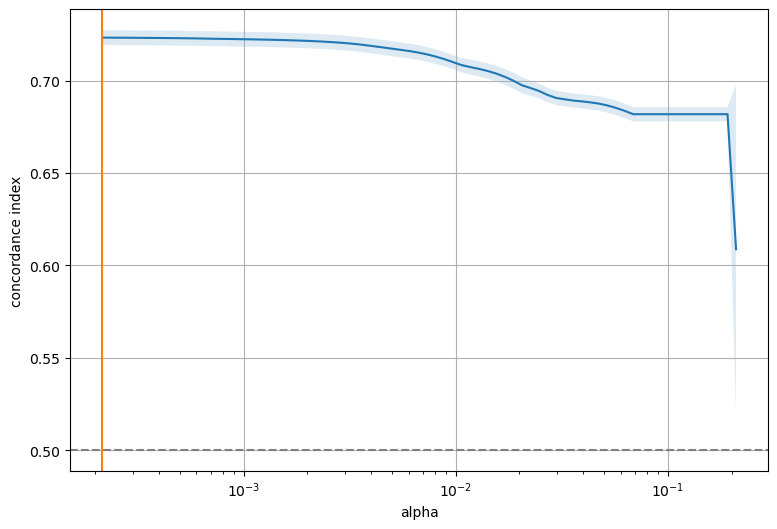

In [316]:
import matplotlib.pyplot as plt

alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [317]:
best_params = gcv.best_params_

coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_params['alphas'][0]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)
_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.723
IBS: 0.136
Mean AUC: 0.743


Concordance Uno: 0.723
IBS: 0.136
Mean AUC: 0.743

Number of non-zero coefficients: 36


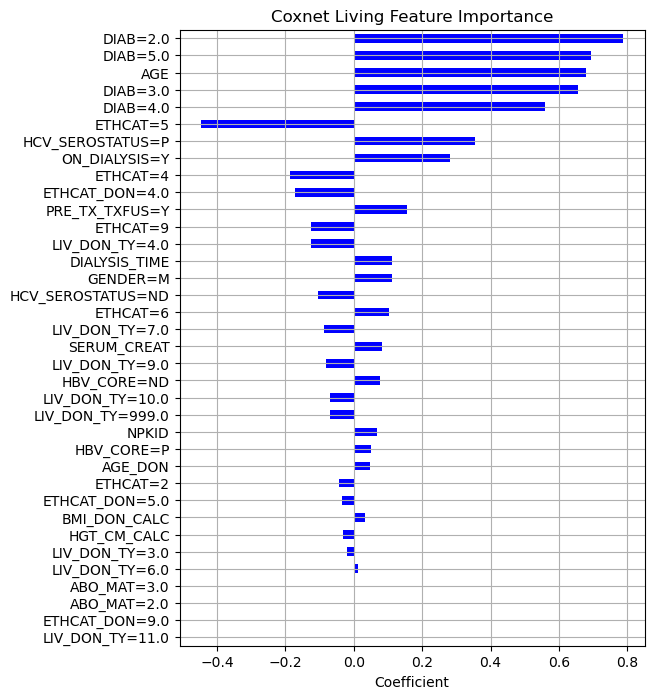

In [318]:
# Visual demonstration of feature importance. Uncomment if features weren't processed with pipeline

best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(best_model.coef_, index=X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False, color='blue')
ax.set_xlabel("Coefficient")
ax.set_title("Coxnet Living Feature Importance")
ax.grid(True)

In [ ]:
import pickle

# pickle_file = 'pickle/COXNET_LIVING_MODEL_FINAL.pickle'

# with open(pickle_file, 'wb') as f:
#     pickle.dump(coxnet_pred, f)


In [ ]:
# keep it commented in order to avoid putting wrong model into the application
# run it only if you are sure that the model and the pipeline are good

# ! bash export_models.sh

In [ ]:
X_train.shape

(42465, 33)

# Pickle model evaluation for later plotting in `result_plot.ipynb`

In [ ]:
from sksurv.metrics import brier_score

# surv_fn = coxnet_pred.predict_survival_function(X_test, return_array=False)

# surv_prob = np.row_stack([fn(times) for fn in surv_fn])

# bs = brier_score(y_train, y_test, surv_prob, times)
# ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
# print('Integrated Brier Score:', ibs)

In [ ]:
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,6))
# plt.plot(bs[0], bs[1], marker=",")
# # plt.axhline(ibs, linestyle="--")
# # plt.text(5, 0, "{model}", fontsize=12)
# plt.title("Time-dependent Brier Score for the Random Survival Forest")
# plt.xlabel("days")
# plt.ylabel("time-dependent Brier Score")

In [ ]:
import pickle
# pickle  the Brier Score of the final model
# with open('pickle/brier/BS_COXNET_LIVING_FINAL.pickle', 'wb') as f:
#     pickle.dump(bs, f)


In [ ]:
# estimation of AUC of final model
# lower, upper = np.percentile(y_train["Days"], [10, 90])
# times = np.arange(lower, upper + 1)
# cph_risk_scores = coxnet_pred.predict(X_test)
# auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

# with open('pickle/AUC/AUC_COXNET_LIVING_FINAL.pickle', 'wb') as f:
#     pickle.dump((times, auc, mean_auc), f)

# Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
# result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [ ]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

# def format_number(x):
#     return '{:.10f}'.format(x)

# importances_df = pd.DataFrame(result.importances_mean, index=X_test.columns)
# importances_df = importances_df.applymap(format_number)
# importances_df.columns = ['Importance']
# importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# # Print out feature importances
# print(importances_df)

                      Importance
AGE                 0.1315698704
DIAB=3.0            0.0173726287
DIAB=5.0            0.0098474493
DIAB=2.0            0.0084824867
ON_DIALYSIS=Y       0.0080707124
DIALYSIS_TIME       0.0050716386
SERUM_CREAT         0.0028699483
PRE_TX_TXFUS=Y      0.0027198157
ETHCAT=5            0.0022618900
NPKID               0.0018685282
HCV_SEROSTATUS=P    0.0015015403
ETHCAT=4            0.0014263265
ETHCAT_DON=4.0      0.0009852106
LIV_DON_TY=4.0      0.0008514676
AGE_DON             0.0008051204
BMI_DON_CALC        0.0005020465
HGT_CM_CALC         0.0004349636
LIV_DON_TY=999.0    0.0003174249
LIV_DON_TY=7.0      0.0001935120
GENDER=M            0.0001824081
LIV_DON_TY=10.0     0.0001771094
DIAB=4.0            0.0001228844
HBV_CORE=ND         0.0000757332
ETHCAT=9            0.0000670046
ETHCAT=6            0.0000316047
ETHCAT_DON=5.0      0.0000167368
ABO_MAT=3.0         0.0000007778
LIV_DON_TY=3.0      0.0000007674
ETHCAT_DON=9.0      0.0000000940
ETHCAT_DON